In [2]:
import os
from pandas import DataFrame
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from time import time

from scipy.stats import zscore
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

import umap

In [3]:
def preparation(data_path, target_path, fillna=False):
    # load data
    df_raw = pd.read_csv(data_path, index_col=False)
    df_raw = df_raw.set_index(['GO term', 'category', 'description'])
    
    if fillna == True:
        df_raw = df_raw.fillna(0)
    else:
        df_raw = df_raw.dropna(how='any',axis=0) 
    
        # Sum feature
    df_raw['total'] = df_raw.sum(axis=1) / (len(df_raw.index))

    # Sort feature by sum of numbers
    df_raw = df_raw.sort_values('total', ascending=True)
    df_raw = df_raw.drop(columns=['total'])
    
    df_raw_target = pd.read_csv(target_path)
    return df_raw, df_raw_target

def normalizing(df_raw, df_raw_target):
    # normalizing by MinMax Scaler
    min_max_scaler = preprocessing.MinMaxScaler()
    scaled_array = min_max_scaler.fit_transform(df_raw)
    df_norm_minmax = pd.DataFrame(scaled_array, columns=df_raw_target.Sample, index=df_raw.index)

    # normalizing by zscore
    df_norm_zscore = df_raw.apply(zscore)

    data_list = [df_raw, df_norm_minmax, df_norm_zscore]

    # Prepare data
    data_raw = df_raw.T
    data_minmax = df_norm_minmax.T
    data_zscore = df_norm_zscore.T
    
    #target
    y = pd.DataFrame(data=list(data_list[0].columns), columns=['Sample'])
    y = pd.concat([y.set_index('Sample'), df_raw_target.set_index('Sample')], axis=1, sort=False)
    y.reset_index(level=0, inplace=True)
    y = y.rename(columns={'index':'Sample'})

    #feature
    x1 = data_raw.values
    x2 = data_minmax.values
    x3 = data_zscore.values

    # Input
    feature = [x1, x2, x3] 
    return data_list, feature, y

def calculate_tsne(X, n_components, perplexities, hue, save=False):
    tsne_result = []
    for i, perplexity in enumerate(perplexities):
        t0 = time()
        tsne = TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
        Y = tsne.fit_transform(X)
        tsne_result.append(Y)
        t1 = time()
        print("z-score, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))

        tSNE_df = pd.DataFrame(data = tsne_result[i], columns = ['component_1', 'component_2'])
        tSNE_df = pd.concat([tSNE_df, pd.DataFrame(y)], axis=1)

        # Set style of scatterplot
        sns.set_context("notebook", font_scale=1.1)
        sns.set_style("whitegrid")

        g = sns.lmplot(x="component_1",
               y="component_2",
               data=tSNE_df,
               legend=True,
               palette="Set2",
               fit_reg=False,
               height=10,
               hue=hue,
               scatter_kws={"s":150, "alpha":0.7})
        plt.title('tSNE Result, perplexity= %d'  % (perplexity), weight='bold').set_fontsize('14') 
        plt.xlabel('Component 1', weight='bold').set_fontsize('10')
        plt.ylabel('Component 2', weight='bold').set_fontsize('10')
        plt.show()
    if save == True:
        return plt.savefig('tSNE.svg')  
    else:
        return plt.show() 

def calculate_PCA(data, y):
    pca = PCA(n_components=3)
    principalComponents = pca.fit_transform(data)
    principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
    finalDf = pd.concat([principalDf, pd.DataFrame(y)], axis=1)
    return finalDf

def visualize_PCA_2D(df, hue, legend=True, save=False):
    # Set style of scatterplot
    sns.set_context("notebook", font_scale=1.1)
    sns.set_style("whitegrid")

    g = sns.lmplot(x="principal component 1",
               y="principal component 2",
               data=df,
               legend=True,
               palette="Set2",
               fit_reg=False,
               height=10,
               hue=hue,
               scatter_kws={"s":150, "alpha":0.7})
    plt.title('PCA Results', weight='bold').set_fontsize('14')
    plt.xlabel('Principal Component 1', weight='bold').set_fontsize('10')
    plt.ylabel('Principal Component 2', weight='bold').set_fontsize('10')
    if save == True:
        return plt.savefig('PCA.svg')  
    else:
        return plt.show()
    
def plot_heatmap(df, scale, save=False):
    plt.figure(figsize = (7,10))
    sns.set(font_scale=0.7) 
    #plt.title(title, fontsize =20)
    sns.heatmap(df, 
                yticklabels=df.index.get_level_values(2),
                cbar_kws={"orientation": "vertical", 'label': scale})
    if save == True:
        return plt.savefig('heatmap.svg')  
    else:
        return plt.show()

def calculate_braycurtis(data):
    df = squareform(pdist(data.T, metric='braycurtis'))
    return df

In [4]:
# Input
data_path = 'GO_result/df_raw_GO_Full.csv'
#target_path = 'output/df_raw_target.csv'
null_target_path = 'target_merge_location_pipe.csv'

df_raw, df_raw_target = preparation(data_path, null_target_path, fillna=True)
df_raw = df_raw.loc[df_raw.index.get_level_values('category') == 'biological_process']
#df_raw_target = pd.read_csv(null_target_path)

In [5]:
df_raw_target.loc[:, 'runs':'pipeline'].groupby('pipeline').count()

,runs,analyses
pipeline,,
2.0,302,302
4.1,390,390


In [6]:
df_drop = df_raw_target.query('pipeline == 2.0').Sample.values
df_raw = df_raw.drop(columns=df_drop)

indexNames = df_raw_target.pipeline[df_raw_target.pipeline == 2.0].index
df_raw_target.drop(indexNames, inplace=True)
print(df_raw.shape)
print(df_raw_target.shape)

(786, 390)
(390, 25)


In [ ]:
'''
y = pd.DataFrame(data=list(data_list[0].columns), columns=['Sample'])
y = pd.concat([y.set_index('Sample'), df_raw_target.set_index('Sample')], axis=1, sort=False)
y.reset_index(level=0, inplace=True)
y = y.rename(columns={'index':'Sample'})
'''

In [7]:
data_list, feature, y = normalizing(df_raw, df_raw_target)
data_list[0]
for num, i in enumerate(data_list):
    d1 = i.T
    S1 = pd.Series(y['Sample'])
    S2 = pd.Series(y['geographic location (country and/or sea,region)'])
    data_list[num] = d1.set_index([S1,S2]).T

In [ ]:
'''
%timeit
for count, i in enumerate(data_list):
    label = ['raw', 'maxmin', 'zscore']
    select = i.T
    select.plot.hist(bins=50, alpha=0.5, legend=False, title=label[count])
'''

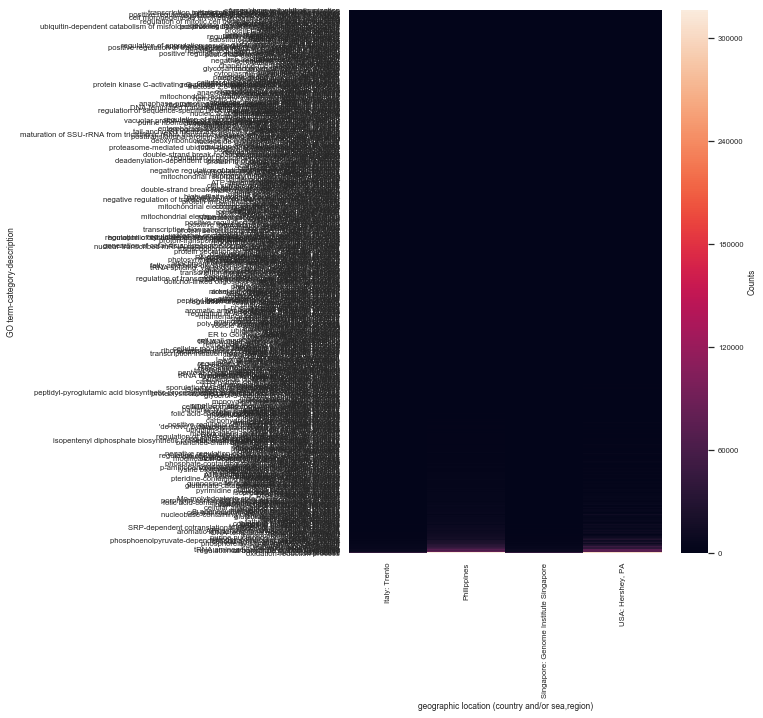

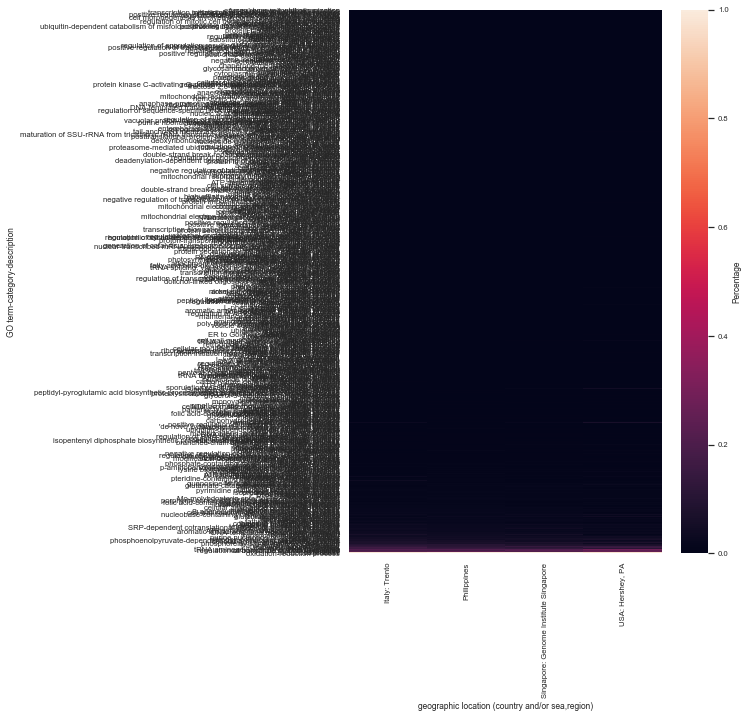

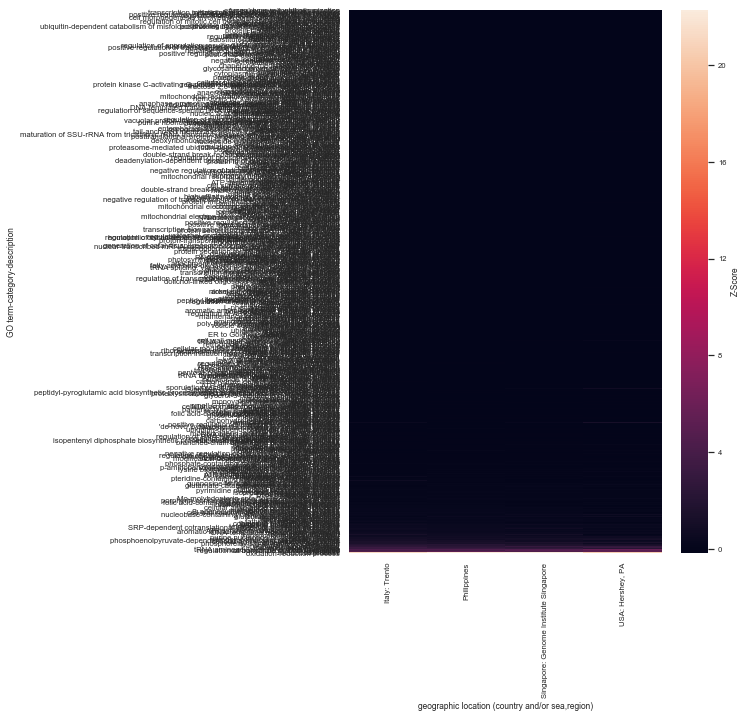

In [8]:
dataframe = [[data_list[0].groupby(level = 1, axis = 1).mean(), "Counts"], 
             [data_list[1].groupby(level = 1, axis = 1).mean(), "Percentage"],
             [data_list[2].groupby(level = 1, axis = 1).mean(), "Z-Score"]
            ]

for i in dataframe:
    plot_heatmap(i[0], i[1], save=True)

In [9]:
y.columns

Index(['Sample', 'MGnify ID', 'Name', 'Description', 'Runs', 'ENA checklist',
       'environment (material)',
       'geographic location (country and/or sea,region)',
       'environment (biome)', 'host scientific name', 'instrument model',
       'geographic location (longitude)', 'sequencing method',
       'environmental package', 'collection date', 'investigation type',
       'host', 'project name', 'last update date',
       'NCBI sample classification', 'environment (feature)',
       'geographic location (latitude)', 'runs', 'analyses', 'pipeline'],
      dtype='object')

In [10]:
y['geographic location (country and/or sea,region)']

0        Philippines
1        Philippines
2        Philippines
3        Philippines
4        Philippines
           ...      
385    Italy: Trento
386    Italy: Trento
387    Italy: Trento
388    Italy: Trento
389    Italy: Trento
Name: geographic location (country and/or sea,region), Length: 390, dtype: object

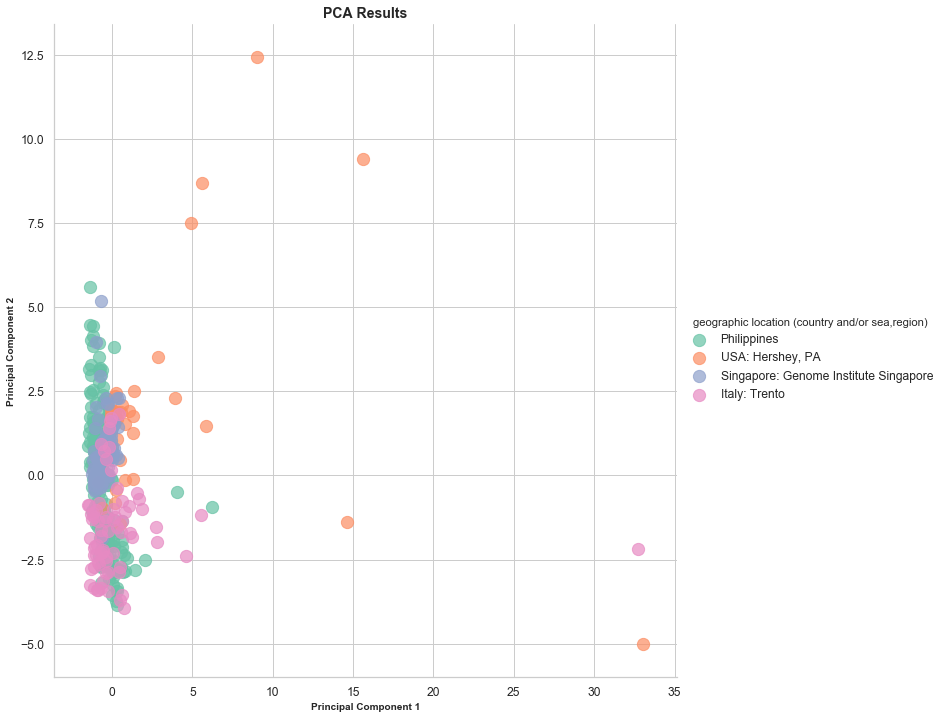

In [11]:
finalDf = calculate_PCA(feature[2], y)
visualize_PCA_2D(finalDf, 'geographic location (country and/or sea,region)', save=True)

In [ ]:
perplexities = [2, 15, 50]
n_components = 2
X = feature[2]
#X = df_braycurtis[2] 
hue = 'geographic location (country and/or sea,region)'
calculate_tsne(X, n_components, perplexities, hue, save=True) 

In [ ]:
embedding = umap.UMAP(n_neighbors=15,
                      min_dist=0.5,
                      n_components=2,
                      metric='braycurtis').fit_transform(feature[2])
UMAP_df = pd.DataFrame(data = embedding, columns = ['component_1', 'component_2'])#, 'component_3'])
UMAP_df = pd.concat([UMAP_df, pd.DataFrame(y)], axis=1)
sns.set_context("notebook", font_scale=1.1)
sns.set_style("whitegrid")
g = sns.lmplot(x='component_1', y='component_2', 
               data=UMAP_df, 
               legend=True, 
               palette="Set2",
               fit_reg=False,
               height=10,
               hue=hue,
               scatter_kws={"s":150, "alpha":0.7})
plt.title('UMAP', weight='bold').set_fontsize('14') 
plt.xlabel('Component 1', weight='bold').set_fontsize('10')
plt.ylabel('Component 2', weight='bold').set_fontsize('10')
plt.savefig('UMAP.svg') 
plt.show()

In [ ]:
df_braycurtis = []

for i in data_list:
    x = calculate_braycurtis(i)
    df_braycurtis.append(x)

"""    
for i in df_braycurtis:
    plt.figure(figsize = (5,5))
    sns.set(font_scale=0.7) 
    #plt.title("title", fontsize =20)

    # Generate a mask for the upper triangle
    mask = np.zeros_like(i, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    sns.heatmap(i, 
                mask=mask,
                #yticklabels=df.index.get_level_values(2),
                cbar_kws={"orientation": "horizontal"})
"""

In [ ]:
from sklearn.manifold import MDS
embedding = MDS(n_components=2, dissimilarity='precomputed')
MDS_transformed = embedding.fit_transform(df_braycurtis[2])
MDS_df = pd.DataFrame(data = MDS_transformed, columns = ['component_1', 'component_2'])#, 'component_3'])
MDS_df = pd.concat([MDS_df, pd.DataFrame(y)], axis=1)

In [ ]:
sns.set_context("notebook", font_scale=1.1)
sns.set_style("whitegrid")
g = sns.lmplot(x='component_1', y='component_2', 
               data=MDS_df, 
               legend=True, 
               palette="Set2",
               fit_reg=False,
               height=10,
               hue=hue,
               scatter_kws={"s":150, "alpha":0.7})
plt.title('PCoA', weight='bold').set_fontsize('14') 
plt.xlabel('Component 1', weight='bold').set_fontsize('10')
plt.ylabel('Component 2', weight='bold').set_fontsize('10')
plt.savefig('PCoA.svg') 
plt.show()


In [12]:
dataframe = [[data_list[0].groupby(level = 1, axis = 1).mean(), "Counts"], 
             [data_list[1].groupby(level = 1, axis = 1).mean(), "Percentage"],
             [data_list[2].groupby(level = 1, axis = 1).mean(), "Z-Score"]
            ]
x = dataframe[2][0]
var = x.var(axis=1)
mean = x.mean(axis=1)

In [13]:
var = list(var.nlargest(40).index.get_level_values(0))

In [14]:
mean.nlargest(40).index.get_level_values(0)

Index(['GO:0055114', 'GO:0008152', 'GO:0006355', 'GO:0006412', 'GO:0006810',
       'GO:0005975', 'GO:0006260', 'GO:0006418', 'GO:0009058', 'GO:0055085',
       'GO:0006508', 'GO:0006265', 'GO:0006351', 'GO:0000160', 'GO:0006281',
       'GO:0006096', 'GO:0006520', 'GO:0006310', 'GO:0006099', 'GO:0009401',
       'GO:0006807', 'GO:0006094', 'GO:0016310', 'GO:0006457', 'GO:0006313',
       'GO:0006164', 'GO:0006352', 'GO:0006814', 'GO:0015986', 'GO:0015074',
       'GO:0015031', 'GO:0000105', 'GO:0043039', 'GO:0008033', 'GO:0006396',
       'GO:0006468', 'GO:0009073', 'GO:0016032', 'GO:0006259', 'GO:0006614'],
      dtype='object', name='GO term')

In [15]:
x[x.index.get_level_values('GO term') == 'GO:0006631']

,,"geographic location (country and/or sea,region)",Italy: Trento,Philippines,Singapore: Genome Institute Singapore,"USA: Hershey, PA"
GO term,category,description,,,,
GO:0006631,biological_process,fatty acid metabolic process,0.273259,0.263968,0.291167,0.214893


In [16]:
total = x.sum(axis=1)

In [58]:
newx = x.divide(total, axis='index')
xvar = newx.var(axis=1)
go_list = list(xvar.nlargest(50).index.get_level_values(0))

In [59]:
toplot = x.loc[go_list,:]

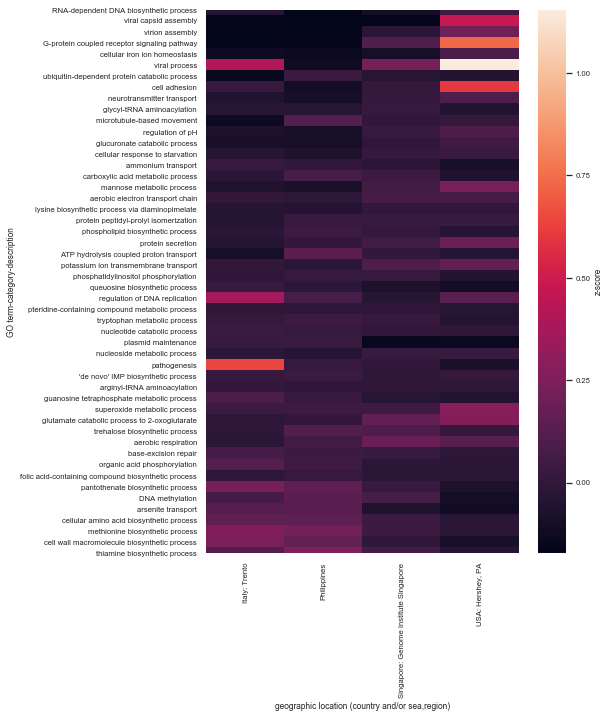

In [60]:
plot_heatmap(toplot, 'z-score', save=True)

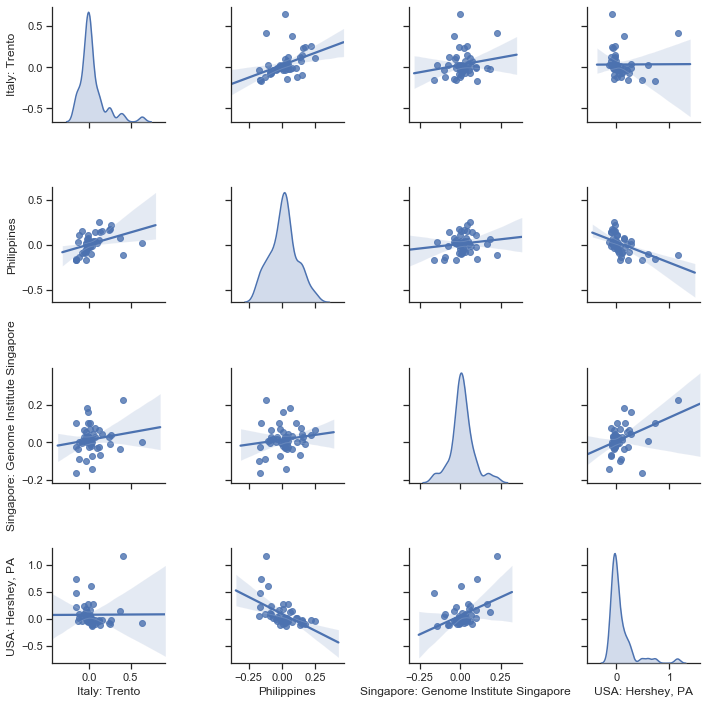

In [61]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(toplot, kind="reg", diag_kind="kde")

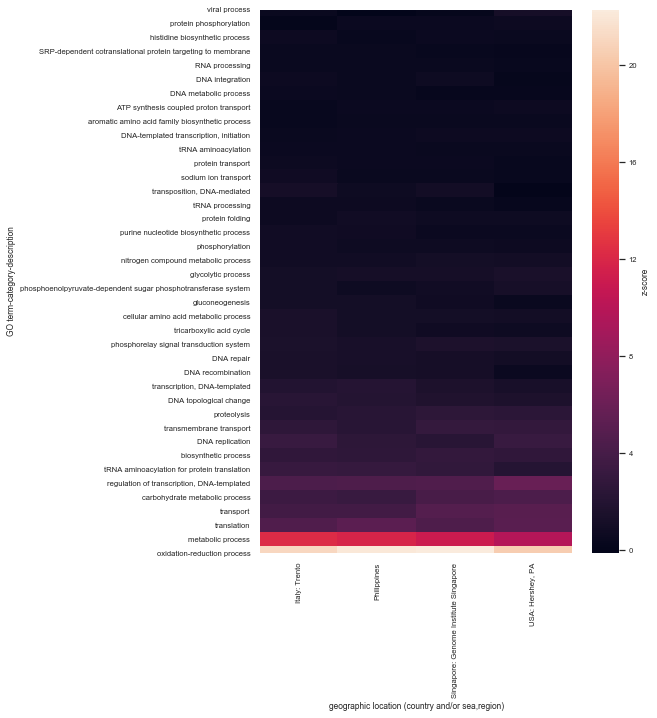

In [54]:
go_list = list(mean.nlargest(40).index.get_level_values(0))
toplot = x.loc[go_list,:]
plot_heatmap(toplot, 'z-score', save=True)

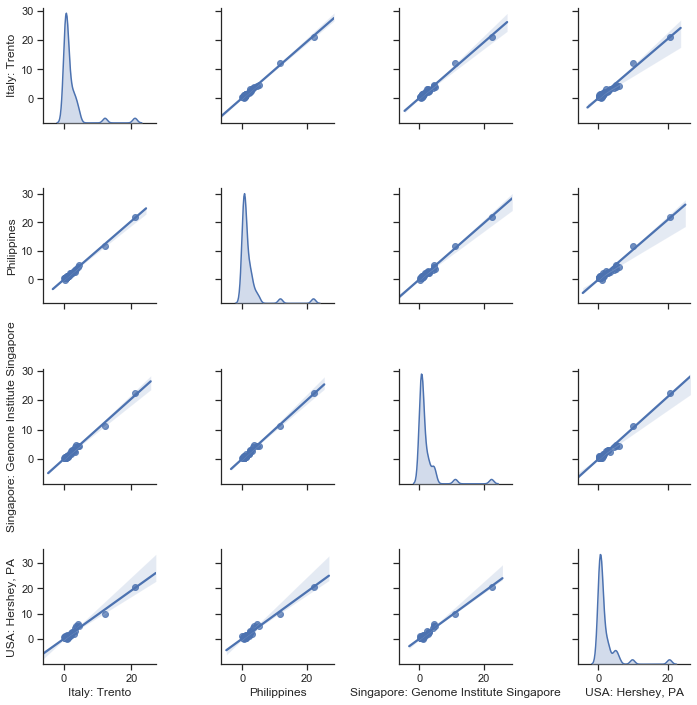

In [57]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(toplot, kind="reg", diag_kind="kde")

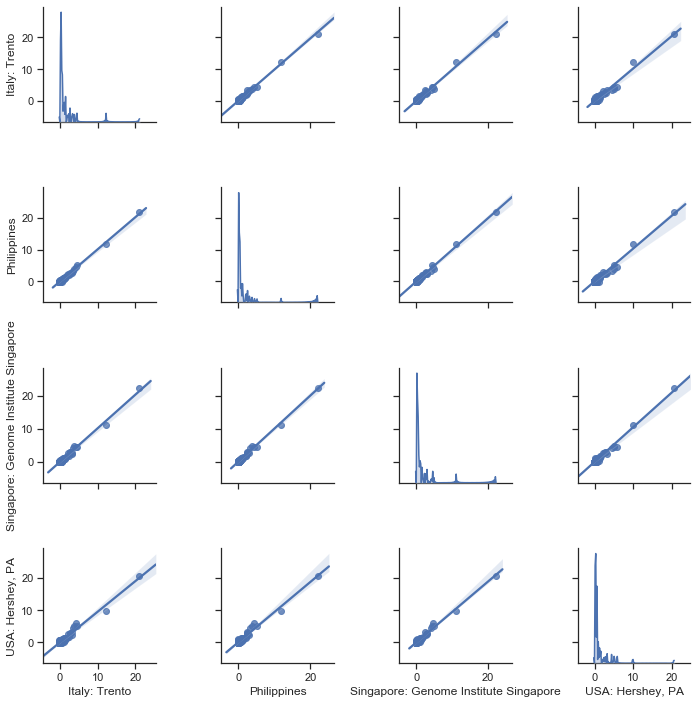

In [62]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(x, kind="reg", diag_kind="kde")